In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# Root Finding and Curve Fitting

# Root Finding: What are Roots?
The **root** of a function is an input that produces an output of zero. For example, $f(x) = x^2 - 4 = (x-2)(x+2)$ has two roots: $x=2$ and $x=-2$

![function with two roots](roots_ex.png)

# Scipy has many functions for finding roots in the `optimize` submodule
- `brentq` (probably what you want): finds a root within a **bracket**
- `brenth`: like `brentq`, but with some numerical differences
- `ridder`: another bracketing method
- `bisect`: yet another bracketing method (we implemented this in a lab long ago)
- `newton`: Uses Newton's method (no bracket required!). Can get stuck at local minima, but **really fast** if you have both the first and second derivatives

Which tool should you use? Depends on the particular function! But for most well-behaved functions, `brentq` will do a great job at a reasonable speed.

# Calling a bracketing function
Calling sequence for a bracketing function typically takes a function/lambda, then the lower limit of the bracket, then the upper limit of the bracket. **The sign of the function must change from one end to another**

In [3]:
from scipy.optimize import brentq
brentq(lambda x: x**2 - 4, -3, 0)

-2.0

In [4]:
brentq(lambda x: x**2 - 4, 0, 3)

2.0

In [5]:
brentq(lambda x: x**2 - 4, -3, 3)

ValueError: f(a) and f(b) must have different signs

# Simply making sure limits have different signs is not enough
These functions will find **A** root, not **ALL** roots. Consider $f(x) = x^3 - 9x$. Sign changes from $x=-4$ to $x=+4$, but there are **three roots** in there!

![function with three roots](roots_ex_2.png)

# Simply making sure limits have different signs is not enough
These functions will find **A** root, not **ALL** roots. Consider $f(x) = x^3 - 9x$. Sign changes from $x=-4$ to $x=+4$, but there are **three roots** in there!

In [6]:
f = lambda x: x**3 - 9 * x
brentq(f, -4, 4)

0.0

Can't guarantee which root we'll get! **You need to be certain your bracket only contains one root.**

In [7]:
print([brentq(f, a, b) for a, b in [(-4, -2), (-1, 1), (2, 4)]])

[-3.0, 0.0, 3.0]


# Root Finding Summary
1. Visualize the function
2. Identify bracketed regions that contain one (and only one) root (which implies that the function changes sign over the region)
3. Call `brentq` with the function, the left endpoint, and the right endpoint

Special scenarios may benefit more from using other bracketing methods, or even `newton` if you have access to the derivatives and know that it won't stall on a local minimum.

# We can use root-finding to solve **transcendental equations**
A transcendental equation is one that involves transcendental functions, like trignometric or logarithmic functions; they rarely have closed-form solutions.

For example:

$$3\ln(x - 1) = \frac{1}{5}x^2 - 9$$

Good luck trying to solve that! Is there even a solution?

# Use visualization (and limiting behaviors) to determine if there are any solutions.
Graph both sides of the equation as separate functions. If the two lines intersect, that is necessarily a point that solves the equation (one $x$ value gives the same $y$ value on both sides). The previous equation has two solutions, it seems.

![transcendental solutions in grpahical form](roots_ex_3.png)

# Cast the equation solution problem into a root-finding problem
$$3\ln(x-1) = \frac{1}{5}x^2 - 9 \quad \Rightarrow \quad f(x) = 3\ln(x-1) - \frac{1}{5}x^2 + 9 = 0$$

In [13]:
# TODO: Find both solutions to the transcendental equation above
def f(x):
    return 3 * np.log(x - 1) - (1 / 5) * x**2 + 9

root_1 = brentq(f, 1.00001, 2)
root_2 = brentq(f, 8, 10)
print(f(root_2))

-1.7763568394002505e-15


# General Equation Solving Summary
1. Use limiting behavior of either side of a function **and** visualization (where plots of the two sides intersect) to determine if solutions exist and roughly where they are.
2. Move one side of the equation to the other to convert problem to a root-finding one
3. Use root-finding methods to solve (brackets can be obtained from regions around intersections of original visualization)

# Curve Fitting: The Situation
- You have some data that can be thought of as $x$ (indepenent) and $y$ (dependent) variables (eg. position vs time, or electric field strength vs position)
- You suspect the underlying physics would predict these values to have a specific mathematical form, like displacement under constant acceleration:
$$ x(t) = x_0 + v_0 t + \frac{1}{2}at^2$$
    (here $x$ is the dependent variable and $t$ is the independent variable) or a sinusoidal wave
$$E(x) = E_0\sin(k x + \phi_0)$$
    (here $E$ is the dependent variable and $x$ is the independent variable)
- You wish to find the best **parameters** for these functions that fit the data most closely ($x_0$, $v_0$, and $a$, or $E_0$, $k$, and $\phi_0$)

# Example: Oscillating Spring
Suppose we measure the displacement of a block on a spring over several periods of oscillation and get the following data:
![noisy data from oscillation experiment](curve-fit-data.png)

# Aside: Plotting Errorbars
Recall that Matplotlib has a nifty `errorbar` function that works like `plot` or `scatter`, but takes additional arrays with symmetric (or asymmetric) uncertainties in $y$ and/or $x$ values. Typically need to specify `fmt` keyword to make data not be joined by lines:

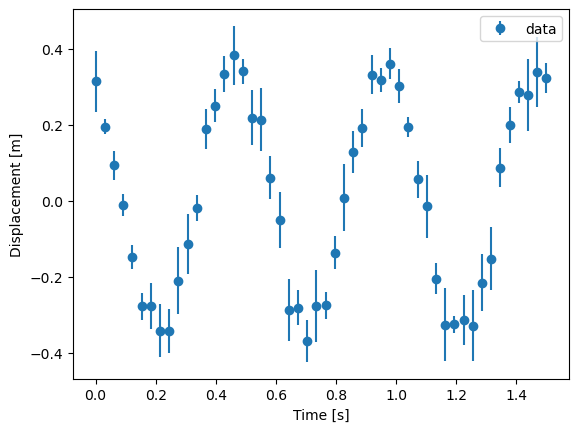

In [2]:
all_data = np.genfromtxt('time-displacements.data', names=True)

# make plot; only pass one array of uncertainties in, assumed for y. A second one would be for x
fig, ax = plt.subplots()
ax.errorbar(all_data['time'], all_data['displacement'], all_data['uncertainty'], fmt='o', label='data')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Displacement [m]')
ax.legend(loc='best')

# The Fitting Function
We expect this data to be some sort of sinusoidal wave of the form
$$d(t) = A\cos(\omega t + \phi_0)$$
We have two types of **data** and three **parameters**:
- Data
    - time ($t$)
    - displacement ($d(t)$)
- Parameters
    - Amplitude ($A$, in meters)
    - Angular frequencey ($\omega$, in rad/s)
    - Initial phase ($\phi_0$, in radians)
    
Goal: find best values for parameters that "fit the data"

In [14]:
from ipywidgets import interactive


def f(A, omega, phi_0):
    fig, ax = plt.subplots()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Displacement [m]')
    ax.set_ylim(-0.6, 0.6)

    ts = np.linspace(np.min(all_data['time']), np.max(all_data['time']))
    ax.errorbar(all_data['time'], all_data['displacement'], all_data['uncertainty'], fmt='o', label='data')
    ax.plot(ts, A * np.cos(omega * ts + phi_0), color='orange', ls='--', label='fit')
    ax.legend(loc='best')
    plt.show()

interactive_plot = interactive(f, A=(0.3, 0.5, 0.025), omega=(10, 20, 0.5), phi_0=(0, 2 * np.pi))
output = interactive_plot.children[-1]
output.layout.height = '250'
interactive_plot

interactive(children=(FloatSlider(value=0.4, description='A', max=0.5, min=0.3, step=0.025), FloatSlider(value…

# The Nonlinear Least Squares Method rigorously computes the best parameters

Goal is to minimize the following quantity:
$$ \chi^2 = \sum_i \left[\frac{f(x_i) - y_i}{\sigma_i}\right]^2$$
- Process sometimes called "chi-squared minimization"
- quantities $f(x_i) - y_i$ are the **residuals**: differences between actual data values of dependent variable and those obtained by plugging independent variable data values into fitting function
- $\sigma_i$ is the uncertainty in measurement $i$. This ensure that highly-uncertain data are weighted less
- actual process of how the method does this is beyond the scope of this class

# Easiest way to do least squares fitting with `scipy.optmize` is `curve_fit`
- You provide:
    - $x$ and $y$ data
    - fitting function of $x$ and each of the free parameters
    - uncertainties in $y$ values (optionally)
- It returns
    - "Best fit" values of each parameter
    - Covariance matrix, which quantifies uncertainties

# Defining the fitting function
Function **must** take independent variable as its first argument, and then the parameters in whatever order you prefer (but remember the order!):

In [15]:
def disp(t, A, omega, phi_0):
    return A * np.cos(omega * t + phi_0)

# Doing an "unweighted" fit
We can fust provide fitting function, data, and an **initial guess** for the parameters (as a tuple), and we get back two objects from `curve_fit`:
- `popt`: **opt**imal **p**arameter values in same order as they appear in the fitting function signature **and** the order of the initial guess
- `pcov`: **cov**ariance matrix: an *n* × *n* array, where *n* is the number of paramters

In [16]:
from scipy.optimize import curve_fit
first_guesses = (0.375, 12.5, 0.4)
popt, pcov = curve_fit(disp, all_data['time'], all_data['displacement'], first_guesses)
A_best, omega_best, phi_0_best = popt
print("Best fit amplitude is {:.3f}".format(A_best))
print("Best fit angular frequency is {:.3f}".format(omega_best))
print("Best fit intial phase is {:.3f}".format(phi_0_best))

Best fit amplitude is 0.349
Best fit angular frequency is 12.543
Best fit intial phase is 0.508


# Checking the unweighted fit

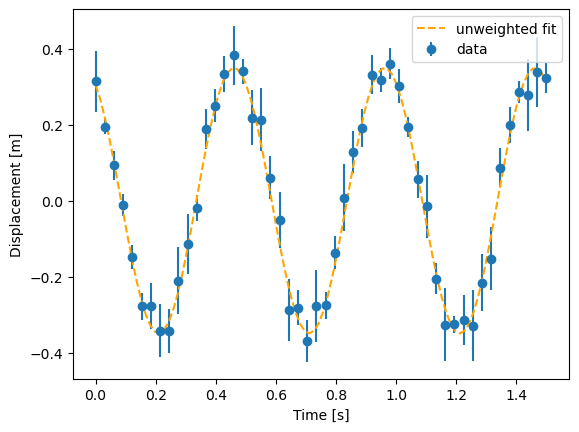

In [17]:
ts_fit = np.linspace(np.min(all_data['time']), np.max(all_data['time']), 100)
ds_fit_unweighted = disp(ts_fit, A_best, omega_best, phi_0_best)

plt.errorbar(all_data['time'], all_data['displacement'], all_data['uncertainty'], fmt='o', label='data')
plt.plot(ts_fit, ds_fit_unweighted, color='orange', ls='--', label='unweighted fit')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend(loc='best')

# That *looks* good, but we can do better: weighted solution
Unweighted fit treats all data points equally, but we really should value fitting through data with smaller uncertainty more than data points with large uncertainties. We can pass in uncertainties to `curve_fit` via the `sigma` keyword, and we can tell `curve_fit` that these are true uncertainties (rather than just ad-hoc weights) by setting `absolute_sigma=True`.

In [18]:
first_guesses = (0.375, 12.5, 0.4)
popt, pcov = curve_fit(disp, all_data['time'], all_data['displacement'], first_guesses, sigma=all_data['uncertainty'], absolute_sigma = True)
A_best, omega_best, phi_0_best = popt
print("Best fit amplitude is {:.3f}".format(A_best))
print("Best fit angular frequency is {:.3f}".format(omega_best))
print("Best fit intial phase is {:.3f}".format(phi_0_best))

Best fit amplitude is 0.347
Best fit angular frequency is 12.551
Best fit intial phase is 0.509


# With weighted solution, covariance matrix is more meaningful
Most important: diagnonal terms. `pcov[i, i]` is the square of the uncertainty in the parameter `popt[i]`. So for our example, we find

In [19]:
print('Best fit amplitude is {:.3f} m ± {:.3f} m'.format(A_best, np.sqrt(pcov[0, 0])))
print('Best fit angular frequency is {:.3f} rad/s ± {:.3f} rad/s'.format(omega_best, np.sqrt(pcov[1, 1])))
print('Best fit initial phase is {:.3f} rad ± {:.3f} rad'.format(phi_0_best, np.sqrt(pcov[2, 2])))

Best fit amplitude is 0.347 m ± 0.009 m
Best fit angular frequency is 12.551 rad/s ± 0.054 rad/s
Best fit initial phase is 0.509 rad ± 0.041 rad


You can still do this to the covariance matrix to get "uncertainties" with an unweighted solution, but it makes certain assumptions (all uncertainties are equal and scaled such that $\chi^2 / N = 1$ where $N$ is the number of points. This is probably not reasonable.

### Shortcut: getting uncertainties from covariance matrix
`np.sqrt(np.diag(pcov))` gives the uncertainties of the paramters in `popt` in the same order. Neato!

# Beware overfitting!
Let's create some random data and try to fit it to a polynomial:

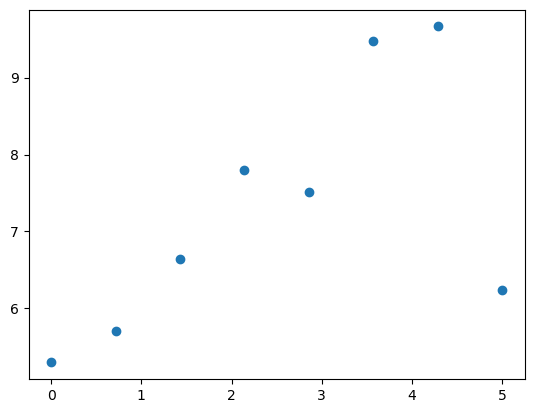

In [22]:
xs = np.linspace(0, 5, 8)
ys = np.random.random_sample(xs.shape) * 5 + 5
plt.scatter(xs, ys)

# Beware overfitting!
We **know** this data is random, but we can create a polynomial that goes through **every point**!

/Users/wmwolf/anaconda3/envs/conda-forge/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


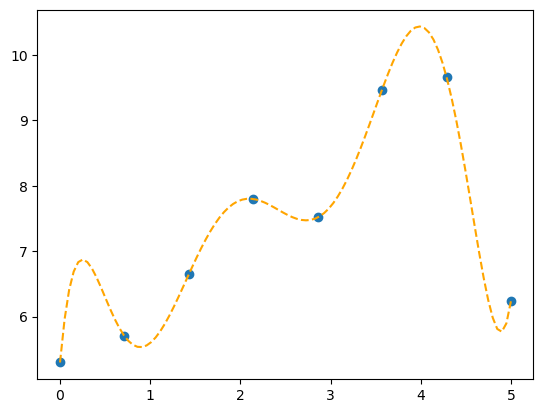

In [23]:
def poly(x, c0, c1, c2, c3, c4, c5, c6, c7):
    return c0 + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4 + c5 * x**5 + c6 * x**6 + c7 * x**7

popt, pcov = curve_fit(poly, xs, ys)
fit_xs = np.linspace(0, 5, 100)
fit_ys = poly(fit_xs, *popt)
plt.scatter(xs, ys)
plt.plot(fit_xs, fit_ys, color='orange', ls='--')

Just because a model fits the data doesn't mean it is meaningful. Ideally, you have far more data points than you have free parameters. In this case, we have equal number of data points and paramters, in which case we can **always** get a meaningless, but "perfect" fit.

# Beware nonsensical models
Models that fit the data but have no basis in physical reality have very little predictive power except very near the existing data.

A comical example: [Trump Administrations "Cubic Model" of Covid-19 Deaths](https://www.vox.com/2020/5/8/21250641/kevin-hassett-cubic-model-smoothing)

# Soutions

In [ ]:
from scipy.optimize import brentq
# Solving for the two unknown roots
f = lambda x: 3 * np.log(x - 1) - 1 / 5 * x**2 + 9
solutions = [brentq(f, a, b) for a, b in [(1.001, 2), (8, 10)]]
solutions

# Source
Cells below create the data and figures used above.

In [ ]:
f = lambda x: x**2 - 4
xs = np.linspace(-3, 3, 100)
ys = f(xs)
pylab.plot(xs, ys, zorder=2, label='$f(x) = x^2 - 4$')
pylab.axhline(0, 0, 1, color='black', lw=2)
pylab.axvline(0, 0, 1, color='black', lw=2)
pylab.scatter([2, -2], [0, 0], color='orange', zorder=3, label='roots')
pylab.xlabel('$x$')
pylab.ylabel('$f(x)$')
pylab.legend(loc='best')
pylab.savefig('roots_ex.png', dpi=150, bbox_inches='tight')

In [ ]:
f = lambda x: x**3 - 9*x
xs = np.linspace(-4, 4, 100)
ys = f(xs)
pylab.plot(xs, ys, zorder=2, label='$f(x) = x^3 - 9x$')
pylab.axhline(0, 0, 1, color='black', lw=2)
pylab.axvline(0, 0, 1, color='black', lw=2)
pylab.scatter([-3, 0, 3], [0, 0, 0], color='orange', zorder=3, label='roots')
pylab.xlabel('$x$')
pylab.ylabel('$f(x)$')
pylab.legend(loc='best')
pylab.savefig('roots_ex_2.png', dpi=150, bbox_inches='tight')

In [ ]:
f1 = lambda x: 3 * np.log(x-1)
f2 = lambda x: 1 / 5 * x**2 - 9
xs = np.linspace(0.001, 10, 100)
ys1 = f1(xs[xs > 1])
ys2 = f2(xs)

sols = np.array([brentq(lambda x: f1(x) - f2(x), a, b) for a, b in [(1, 2), (6, 10)]])

pylab.plot(xs[xs>1], ys1, label='$f(x) = 3\ln(x - 1)$')
pylab.plot(xs, ys2, ls='--', label=r'$f(x) = \frac{1}{5}x^2 - 9$')
pylab.scatter(sols, f1(sols), color='black', label='solutions', zorder=5)
pylab.ylim(-11, 8)
pylab.legend(loc='best')
pylab.xlabel('$x$')
pylab.ylabel('$f(x)$')

pylab.text(10, -3, 'Two solutions!', ha='right', va='bottom')

pylab.savefig('roots_ex_3.png', dpi=150, bbox_inches='tight')

In [ ]:
# ALL CODE DOWN TO THE CALL TO genfromtxt CREATES NOISY COSINE DATA AND SAVES TO A FILE

# f = 2 # Hz
# omega = 2 * np.pi * f
# period = 1/f
# phi_0 = np.pi/6

# amplitude = 0.34 # M

# times = np.linspace(0, 3 * period)
# displacements = amplitude * np.cos(omega * times + phi_0)

# # get randomly distributed uncertainteis (not errors; just uncertainties)
# min_uncertainty = 0.02
# max_uncertainty = 0.1
# uncertainties = min_uncertainty + np.random.random_sample(times.shape) * (max_uncertainty - min_uncertainty)

# # now generate error noise by adding something between -uncertainty and +uncertainty
# # to every displacement
# errors = uncertainties * (2 * np.random.random_sample(uncertainties.shape) - 1.0)
# displacements += errors

# dt = np.dtype([('time', 'float64'), ('displacement', 'float64'), ('uncertainty', 'float64')])
# all_data = np.zeros(len(times), dtype=dt)
# all_data['time'] = times
# all_data['displacement'] = displacements
# all_data['uncertainty'] = uncertainties
# np.savetxt('time-displacements.data', all_data, delimiter='\t', header='\t'.join(['{:12s}'.format(name) for name in dt.names]), fmt='%12.6e')

all_data = np.genfromtxt('time-displacements.data', names=True)

# make plot
pylab.errorbar(all_data['time'], all_data['displacement'], all_data['uncertainty'], fmt='o', label='data')
pylab.xlabel('Time [s]')
pylab.ylabel('Displacement [m]')
pylab.legend(loc='best')
pylab.savefig('curve-fit-data.png', dpi=150, bbox_inches='tight')